In [10]:

import os
import sys
import json
import datetime
import numpy as np
import skimage.draw

from mrcnn.visualize import display_instances, display_top_masks
from mrcnn.utils import extract_bboxes

from mrcnn.utils import Dataset
from matplotlib import pyplot as plt

from mrcnn.config import Config
from mrcnn.model import MaskRCNN


from mrcnn import model as modellib, utils
from PIL import Image, ImageDraw
import math
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image
from mrcnn.utils import compute_ap
from numpy import expand_dims
from numpy import mean
from matplotlib.patches import Rectangle

In [11]:
ROOT_DIR = os.getcwd()
# ROOT_DIR = os.path.abspath('./')
# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
# Directory to save logs and trained model
# DEFAULT_LOGS_DIR = 'D:/mask_rcnn_tutorial/Mask_RCNN_TF2_master/kangaroo_transfer_learning/logdir'
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, 'logs')


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  640
IMAGE_META_SIZE                19
IMAGE_MIN_DIM                  426
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [640 640   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

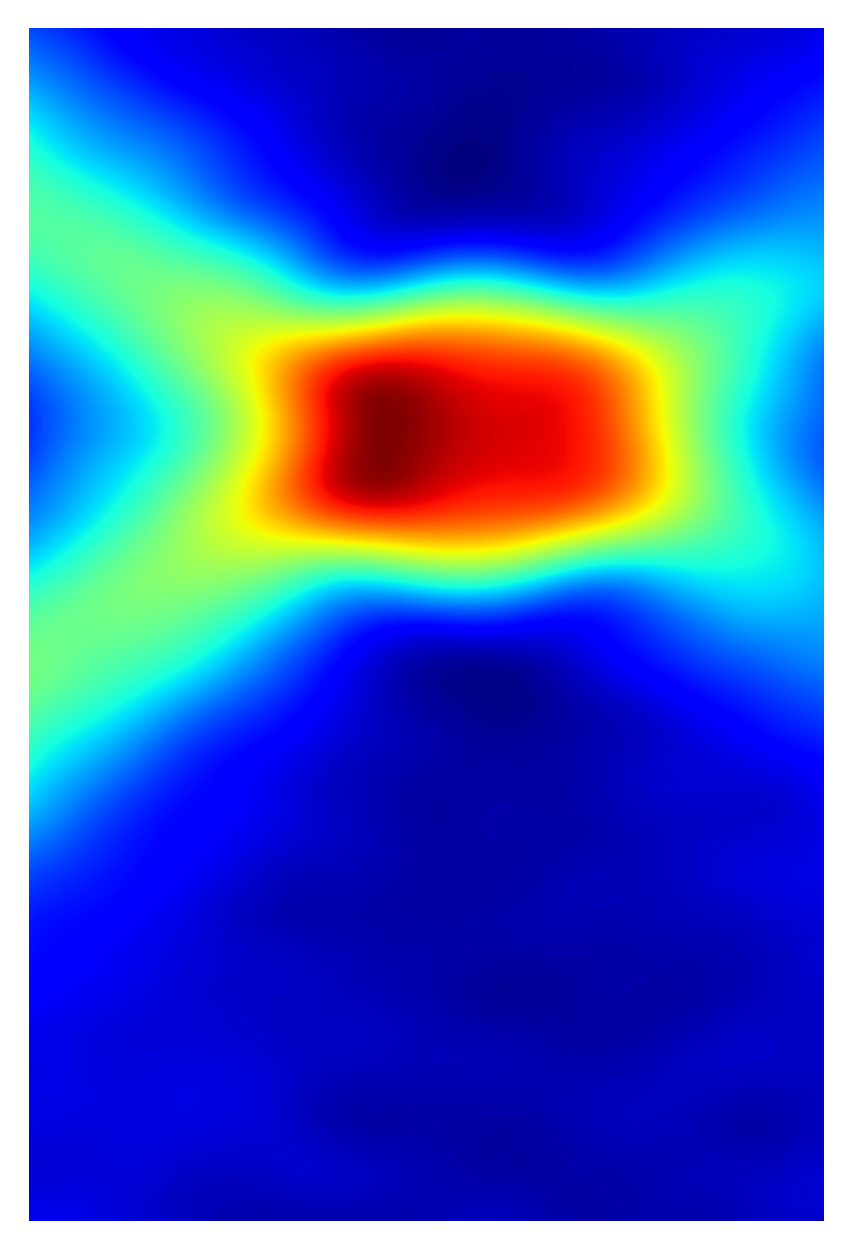

In [12]:
# https://youtu.be/QntADriNHuk
"""
Mask R-CNN - Multiclass - Coco style annotations in JSON format

For annotations, use one of the following programs:
    https://www.makesense.ai/
    https://labelstud.io/
    https://github.com/Doodleverse/dash_doodler
    http://labelme.csail.mit.edu/Release3.0/
    https://github.com/openvinotoolkit/cvat
    https://www.robots.ox.ac.uk/~vgg/software/via/

"""

import os
import sys
import json
import datetime
import numpy as np
import skimage.draw

from mrcnn.visualize import display_instances, display_top_masks
from mrcnn.utils import extract_bboxes

from mrcnn.utils import Dataset
from matplotlib import pyplot as plt

from mrcnn.config import Config
from mrcnn.model import MaskRCNN

from mrcnn import model as modellib, utils
from PIL import Image, ImageDraw
import math


# ROOT_DIR= os.getcwd()
# DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")
# print(DEFAULT_LOGS_DIR)


class CocoLikeDataset(utils.Dataset):
    """ Generates a COCO-like dataset, i.e. an image dataset annotated in the style of the COCO dataset.
        See http://cocodataset.org/#home for more information.
    """

    def load_data(self, annotation_json, images_dir):
        """ Load the coco-like dataset from json
        Args:
            annotation_json: The path to the coco annotations json file
            images_dir: The directory holding the images referred to by the json file
        """
        # Load json from file
        json_file = open(annotation_json)
        coco_json = json.load(json_file)
        json_file.close()

        # Add the class names using the base method from utils.Dataset
        source_name = "coco_like"
        for category in coco_json['categories']:
            class_id = category['id']
            class_name = category['name']
            if class_id < 1:
                print('Error: Class id for "{}" cannot be less than one. (0 is reserved for the background)'.format(
                    class_name))
                return

            self.add_class(source_name, class_id, class_name)

        # Get all annotations
        annotations = {}
        for annotation in coco_json['annotations']:
            image_id = annotation['image_id']
            if image_id not in annotations:
                annotations[image_id] = []
            annotations[image_id].append(annotation)

        # Get all images and add them to the dataset
        seen_images = {}
        for image in coco_json['images']:
            image_id = image['id']
            if image_id in seen_images:
                print("Warning: Skipping duplicate image id: {}".format(image))
            else:
                seen_images[image_id] = image
                try:
                    image_file_name = image['file_name']
                    image_width = image['width']
                    image_height = image['height']
                except KeyError as key:
                    print("Warning: Skipping image (id: {}) with missing key: {}".format(image_id, key))

                image_path = os.path.abspath(os.path.join(images_dir, image_file_name))
                image_annotations = annotations[image_id]

                # Add the image using the base method from utils.Dataset
                self.add_image(
                    source=source_name,
                    image_id=image_id,
                    path=image_path,
                    width=image_width,
                    height=image_height,
                    annotations=image_annotations
                )

    def load_mask(self, image_id):
        """ Load instance masks for the given image.
        MaskRCNN expects masks in the form of a bitmap [height, width, instances].
        Args:
            image_id: The id of the image to load masks for
        Returns:
            masks: A bool array of shape [height, width, instance count] with
                one mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        image_info = self.image_info[image_id]
        annotations = image_info['annotations']
        instance_masks = []
        class_ids = []

        for annotation in annotations:
            class_id = annotation['category_id']
            mask = Image.new('1', (image_info['width'], image_info['height']))
            mask_draw = ImageDraw.ImageDraw(mask, '1')
            for segmentation in annotation['segmentation']:
                mask_draw.polygon(segmentation, fill=1)
                bool_array = np.array(mask) > 0
                instance_masks.append(bool_array)
                class_ids.append(class_id)

        mask = np.dstack(instance_masks)
        class_ids = np.array(class_ids, dtype=np.int32)

        return mask, class_ids


##############################

dataset_train = CocoLikeDataset()
dataset_train.load_data('marble_dataset/train/labels/high_resolution_lang_6classes_train_3sets_elastic_sony.json',
                        'marble_dataset/train')
dataset_train.prepare()

#In this example, I do not have annotations for my validation data, so I am loading train data
dataset_val = CocoLikeDataset()
dataset_val.load_data('marble_dataset/train/labels/val_high_resolution_lang_6classes_train_3sets_elastic_sony.json',
                      'marble_dataset/train')
dataset_val.prepare()

dataset = dataset_train
image_ids = dataset.image_ids
#image_ids = np.random.choice(dataset.image_ids, 3)
# for image_id in image_ids:
#     image = dataset.load_image(image_id)
#     mask, class_ids = dataset.load_mask(image_id)
#     display_top_masks(image, mask, class_ids, dataset.class_names, limit=2)  #limit to total number of classes


# define image id
image_id = 0
# load the image
image = dataset_train.load_image(image_id)
# load the masks and the class ids
mask, class_ids = dataset_train.load_mask(image_id)

# display_instances(image, r1['rois'], r1['masks'], r1['class_ids'],
# dataset.class_names, r1['scores'], ax=ax, title="Predictions1")

# extract bounding boxes from the masks
bbox = extract_bboxes(mask)
# display image with masks and bounding boxes
# display_instances(image, bbox, mask, class_ids, dataset_train.class_names)


# define a configuration for the model
class MarbleConfig(Config):
    # define the name of the configuration
    NAME = "marble_cfg_coco"
    # number of classes (background + blue marble + non-Blue marble)
    NUM_CLASSES = 1 + 6
    # number of training steps per epoch
    STEPS_PER_EPOCH = 200


#DETECTION_MIN_CONFIDENCE = 0.9 # Skip detections with < 90% confidence
# prepare config
config = MarbleConfig()
config.display()

ROOT_DIR = os.getcwd()
# ROOT_DIR = os.path.abspath('./')
# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
# Directory to save logs and trained model
# DEFAULT_LOGS_DIR = 'D:/mask_rcnn_tutorial/Mask_RCNN_TF2_master/kangaroo_transfer_learning/logdir'
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, 'logs')
print(DEFAULT_LOGS_DIR)
# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coc.h5")

########################
#Weights are saved to root D: directory. need to investigate how they can be
#saved to the directory defined... "logs_models"

###############

# define the model
model = MaskRCNN(mode='training', model_dir=DEFAULT_LOGS_DIR, config=config)
# load weights (mscoco) and exclude the output layers
model.load_weights(filepath='D:/mask_rcnn_tutorial/Mask_RCNN_TF2_master/kangaroo_transfer_learning/mask_rcnn_coco.h5',
                   by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])
# train weights (output layers or 'heads')
# model.train(dataset_train, dataset_train, learning_rate=config.LEARNING_RATE, epochs=500, layers='all')

# model.keras_model.save_weights('mask_rcnn_marble_cfg_coco.h5')
###################################################
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image
from mrcnn.utils import compute_ap
from numpy import expand_dims
from numpy import mean
from matplotlib.patches import Rectangle


# define the prediction configuration
class PredictionConfig(Config):
    # define the name of the configuration
    NAME = "marble_cfg_coco"
    # number of classes (background + Blue Marbles + Non Blue marbles)
    NUM_CLASSES = 1 + 6
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1


# calculate the mAP for a model on a given dataset
def evaluate_model(dataset, model, cfg):
    APs = list()
    for image_id in dataset.image_ids:
        # load image, bounding boxes and masks for the image id
        image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
        # convert pixel values (e.g. center)
        scaled_image = mold_image(image, cfg)
        # convert image into one sample
        sample = expand_dims(scaled_image, 0)
        # make prediction
        yhat = model.detect(sample, verbose=0)
        # extract results for first sample
        r = yhat[0]
        # calculate statistics, including AP
        AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
        # store
        APs.append(AP)
    # calculate the mean AP across all images
    mAP = mean(APs)
    return mAP


# create config
cfg = PredictionConfig()
# define the model
model = MaskRCNN(mode='inference', model_dir=DEFAULT_LOGS_DIR, config=cfg)
# load model weights
model.load_weights('D:/mask_rcnn_tutorial/Mask_RCNN_TF2_master/kangaroo_transfer_learning/logs/marble_cfg_coco20221219T1211/mask_rcnn_marble_cfg_coco_0500.h5', by_name=True)
# evaluate model on training dataset
# train_mAP = evaluate_model(dataset_train, model, cfg)
# print("Train mAP: %.3f" % train_mAP)
# evaluate model on test dataset
# test_mAP = evaluate_model(dataset_train, model, cfg)
# print("Test mAP: %.3f" % test_mAP)

#################################################
#Test on a single image
marbles_img = np.load(r"D:\PycharmProjects\Hiddencrack\tf-keras-frcnn\random_cropped_15_lang\images\circle1_2p5/076circle1_2p5_1.npy")
marbles_img_1 = marbles_img[:,:,0]
# plt.imshow(marbles_img[:,:,0])

detected = model.detect([marbles_img])
results = detected[0]
print(results)
class_names = ['BG', 'line-0.5mm', 'circle-0.5mm','line-1.5mm', 'circle-1.5mm','line-2.5mm', 'circle-2.5mm']
display_instances(marbles_img, results['rois'], results['masks'],
                  results['class_ids'], class_names, results['scores'])


###############################


##############################################

#Show detected objects in color and all others in B&W
# def color_splash(img, mask):
#     """Apply color splash effect.
#     image: RGB image [height, width, 3]
#     mask: instance segmentation mask [height, width, instance count]
#     Returns result image.
#     """
#     # Make a grayscale copy of the image. The grayscale copy still
#     # has 3 RGB channels, though.
#     gray = np.load(r"D:\PycharmProjects\Hiddencrack\tf-keras-frcnn\random_cropped_15_lang\images\circle_2p5/076circle_2p5_1.npy")
#     # Copy color pixels from the original color image where mask is set
#     if mask.shape[-1] > 0:
#         # We're treating all instances as one, so collapse the mask into one layer
#         mask = (np.sum(mask, -1, keepdims=True) >= 1)
#         splash = np.where(mask, img, gray).astype(np.uint8)
#     else:
#         splash = gray.astype(np.uint8)
#     return splash
#
#
# import skimage
#
#
# def detect_and_color_splash(model, image_path=None, video_path=None):
#     assert image_path or video_path
#
#     # Image or video?
#     if image_path:
#         # Run model detection and generate the color splash effect
#         #print("Running on {}".format(img))
#         # Read image
#         img = np.load(r"D:\PycharmProjects\Hiddencrack\tf-keras-frcnn\random_cropped_15_lang\images\circle_2p5/076circle_2p5_1.npy")
#         # Detect objects
#         r = model.detect([img], verbose=1)[0]
#         # Color splash
#         splash = color_splash(img, r['masks'])
#         # Save output
#         file_name = "splash_{:%Y%m%dT%H%M%S}.png".format(datetime.datetime.now())
#         skimage.io.imsave(file_name, splash)
#     elif video_path:
#         import cv2
#         # Video capture
#         vcapture = cv2.VideoCapture(video_path)
#         width = int(vcapture.get(cv2.CAP_PROP_FRAME_WIDTH))
#         height = int(vcapture.get(cv2.CAP_PROP_FRAME_HEIGHT))
#         fps = vcapture.get(cv2.CAP_PROP_FPS)
#
#         # Define codec and create video writer
#         file_name = "splash_{:%Y%m%dT%H%M%S}.avi".format(datetime.datetime.now())
#         vwriter = cv2.VideoWriter(file_name,
#                                   cv2.VideoWriter_fourcc(*'MJPG'),
#                                   fps, (width, height))
#
#         count = 0
#         success = True
#         while success:
#             print("frame: ", count)
#             # Read next image
#             success, img = vcapture.read()
#             if success:
#                 # OpenCV returns images as BGR, convert to RGB
#                 img = img[..., ::-1]
#                 # Detect objects
#                 r = model.detect([img], verbose=0)[0]
#                 # Color splash
#                 splash = color_splash(img, r['masks'])
#                 # RGB -> BGR to save image to video
#                 splash = splash[..., ::-1]
#                 # Add image to video writer
#                 vwriter.write(splash)
#                 count += 1
#         vwriter.release()
#     print("Saved to ", file_name)
#
#
# detect_and_color_splash(model, image_path=r"D:\PycharmProjects\Hiddencrack\tf-keras-frcnn\random_cropped_15_lang\images\circle_2p5/076circle_2p5_1.npy")

######################################################